In [1]:
import sys

sys.path.append('../../../')

import glob
import pickle
import numpy as np
import pandas as pd
import pywt
from micromlgen import port
import librosa
from scipy.stats import skew
from sklearn.svm import OneClassSVM, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn_rvm.em_rvm import EMRVC
from Pipeline.Cascade.Detection.optimization import detection_report
from Pipeline.filtering import butter_bandpass_filter
from Pipeline.evaluation import plot_confusion_matrix
from Pipeline.Cascade.Classification.sefr import SEFRMultiClass

In [2]:
# Set seed for experiment reproducibility
seed = 1
np.random.default_rng(seed)

Generator(PCG64) at 0x25CCA872260

In [ ]:
extract_autocorr = lambda signal: librosa.autocorrelate(signal)
(ca, cd) = lambda signal: pywt.dwt(signal, 'db1')

In [ ]:
def autocorr(x):
    n = x.size
    norm = (x - np.mean(x))
    result = np.correlate(norm, norm, mode='same')
    acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
    lag = np.abs(acorr).argmax() + 1
    r = acorr[lag-1]
    if np.abs(r) > 0.5:
      print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
    else:
      print('Appears to be not autocorrelated')
    return r, lag

In [3]:
# Generate mfcc features with mean and standard deviation
def get_mfcc(signal, sr):
    ft1 = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=30).astype(np.float32)
    ft2 = librosa.feature.zero_crossing_rate(y=signal)[0].astype(np.float32)
    ft3 = librosa.feature.rms(y=signal)[0].astype(np.float32)
    ft4 = librosa.feature.spectral_rolloff(y=signal)[0].astype(np.float32)
    ft5 = librosa.feature.spectral_centroid(y=signal)[0].astype(np.float32)
    ft6 = librosa.feature.spectral_contrast(y=signal)[0].astype(np.float32)
    ft7 = librosa.feature.spectral_bandwidth(y=signal)[0].astype(np.float32)

    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    ft7_trunc = np.hstack((np.mean(ft7), np.std(ft7), skew(ft7), np.max(ft7), np.median(ft7), np.max(ft7)))
    return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc, ft7_trunc)))

In [4]:
def extract_features(path, one_class=False):
    features = []
    labels = []

    for file in glob.glob(f'{path}', recursive=True):
        signal, sr = librosa.load(file, sr=44100)
        signal = butter_bandpass_filter(signal, 200, 20000, sr, 2)
        features.append(get_mfcc(signal, sr))
        if one_class:
            if 'background' in file:
                labels.append(-1)
            else:
                labels.append(1)
        else:
            if 'Background' in file:
                labels.append(0)
            elif 'Big mandibles' in file:
                labels.append(1)
            elif 'Small mandibles' in file:
                labels.append(2)

    return np.asarray(features), np.asarray(labels)


In [6]:
features, labels = extract_features("../../../Dataset/Final dataset/Generation/Generated dataset/**/*.wav", one_class=False)
features

array([[-6.19604065e+02,  3.64511604e+01,  7.64081776e-01, ...,
         3.01480176e+03,  2.97012769e+03,  3.01480176e+03],
       [-6.51916016e+02,  4.75715866e+01, -2.06579151e+01, ...,
         2.67317993e+03,  2.66407593e+03,  2.67317993e+03],
       [-5.62815063e+02,  1.02959129e+02, -7.19623260e+01, ...,
         2.10999341e+03,  1.97896021e+03,  2.10999341e+03],
       ...,
       [-6.13615234e+02,  2.42212105e+01, -7.03043509e+00, ...,
         3.00191479e+03,  2.97541821e+03,  3.00191479e+03],
       [-4.68278412e+02,  4.51767540e+00, -9.62499905e+00, ...,
         2.94684204e+03,  2.84444556e+03,  2.94684204e+03],
       [-6.42090149e+02,  7.90605087e+01, -6.63767395e+01, ...,
         2.21561865e+03,  1.91287109e+03,  2.21561865e+03]])

In [19]:
features

array([[ 0.02717879,  0.08137403,  1.03015441, ...,  0.85942507,
         1.07355306,  0.85942507],
       [-0.46473224,  0.43221887,  0.33839211, ...,  0.0120385 ,
         0.37546662,  0.0120385 ],
       [ 0.89172381,  2.17967287, -1.31833752, ..., -1.38493517,
        -1.18724291, -1.38493517],
       ...,
       [ 0.11835162, -0.30447582,  0.77845272, ...,  0.8274592 ,
         1.08562045,  0.8274592 ],
       [ 2.33093192, -0.92611418,  0.69466867, ...,  0.69085226,
         0.78687936,  0.69085226],
       [-0.3151451 ,  1.4256813 , -1.13796693, ..., -1.12293372,
        -1.33798837, -1.12293372]])

In [7]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [8]:
# Apply PCA for dimension reduction
pca = PCA(n_components=50).fit(features)
features_pca = pca.transform(features)

print(sum(pca.explained_variance_ratio_))

0.5634463568495978


# Multi-class SVM

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=seed)

In [60]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(gamma='auto')

In [61]:
prediction = clf.predict(X_test)
print(classification_report(np.asarray(y_test), prediction))

              precision    recall  f1-score   support

           0       0.67      0.89      0.76       186
           1       0.86      0.68      0.76       206
           2       0.80      0.74      0.77       208

    accuracy                           0.76       600
   macro avg       0.78      0.77      0.76       600
weighted avg       0.78      0.76      0.76       600



In [ ]:
pickle.dump(clf, open('../../../Models/baseline/svm/svm_model.sav', 'wb'))
pickle.dump(port(clf), open('../../../Models/baseline/svm/svm_model.c', 'wb'))

# One-class SVM: Background vs Insect Classes

In [ ]:
X = features[labels == 1]
y = labels[labels == 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [48]:
clf = OneClassSVM(gamma='auto')
clf.fit(X_train)

OneClassSVM(gamma='auto')

In [49]:
prediction = clf.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.40      0.57       120

    accuracy                           0.40       120
   macro avg       0.50      0.20      0.29       120
weighted avg       1.00      0.40      0.57       120



C:\Users\loren\anaconda3\envs\tinyML-thesis\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\loren\anaconda3\envs\tinyML-thesis\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\loren\anaconda3\envs\tinyML-thesis\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
X_test = np.vstack((X_test, features[labels == -1][0:20]))
y_test = np.hstack((y_test, labels[labels == -1][0:20]))

In [9]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [10]:
X_test, y_test = unison_shuffled_copies(X_test, y_test)

In [53]:
prediction = clf.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

          -1       0.09      0.35      0.14        20
           1       0.79      0.40      0.53       120

    accuracy                           0.39       140
   macro avg       0.44      0.38      0.34       140
weighted avg       0.69      0.39      0.47       140



In [54]:
y_true = y_test.copy()
y_pred = prediction.copy()

y_true[y_true == -1] = 0
y_pred[y_pred == -1] = 0
detection_report(y_true, y_pred)


Evaluation on the test set:
False alarm prob: 65.0%
Miss detection prob: 60.0%
Number of False Positives: 13
Number of False Negatives: 72
Detector f1-score is 53.038674%

Other Metrics:
Detector accuracy is 39.285714%
Detector precision is 78.688525%
Detector recall is 40.000000%


# One-class SVM: Ensemble

In [20]:
classes = ['Background', 'Big mandibles', 'Small mandibles']

In [21]:
ground_truth_list = []
for i in range(0, len(classes)):
    ground_truth = []
    for label in y_train:
        if label == i:
            ground_truth.append(1)
        else:
            ground_truth.append(-1)

    ground_truth_list.append(np.asarray(ground_truth))

In [49]:
def train_occ(features, ground_truth_list, classes):
    base_occs = []

    for index in range(len(classes)):
        labels = ground_truth_list[index]

        X = features[ground_truth_list[index] == 1]
        y = labels[labels == 1]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

        # nu needs to be tuned
        clf = OneClassSVM(gamma='auto', nu=0.3)
        clf.fit(X_train)

        base_occs.append(clf)

        X_test = np.vstack((X_test, features[ground_truth_list[index] == -1]))
        y_test = np.hstack((y_test, labels[labels == -1]))

        prediction = clf.predict(X_test)

        print(f'Class: {classes[index]}')
        y_true = y_test.copy()
        y_pred = prediction.copy()

        y_true[y_true == -1] = 0
        y_pred[y_pred == -1] = 0
        detection_report(y_true, y_pred)
        print('----------------------------------------')
    return base_occs

In [50]:
base_occs = train_occ(X_train.copy(), ground_truth_list, classes)

Class: Background

Evaluation on the test set:
False alarm prob: 13.18%
Miss detection prob: 63.19%
Number of False Positives: 209
Number of False Negatives: 103
Detector f1-score is 27.777778%

Other Metrics:
Detector accuracy is 82.161235%
Detector precision is 22.304833%
Detector recall is 36.809816%
----------------------------------------
Class: Big mandibles

Evaluation on the test set:
False alarm prob: 22.48%
Miss detection prob: 68.55%
Number of False Positives: 361
Number of False Negatives: 109
Detector f1-score is 17.543860%

Other Metrics:
Detector accuracy is 73.371105%
Detector precision is 12.165450%
Detector recall is 31.446541%
----------------------------------------
Class: Small mandibles

Evaluation on the test set:
False alarm prob: 16.67%
Miss detection prob: 57.23%
Number of False Positives: 268
Number of False Negatives: 91
Detector f1-score is 27.474747%

Other Metrics:
Detector accuracy is 79.683079%
Detector precision is 20.238095%
Detector recall is 42.7672

In [51]:
# Multi class prediction ensembling the scores of the one-class classifiers
def predict(X_test, base_occs):
    scores = []
    for clf in base_occs:
        scores.append(clf.decision_function(X_test))

    scores = np.asarray(scores)
    scores = np.transpose(scores)

    predictions = []
    for s in scores:
        predictions.append(np.argmax(s))

    return np.asarray(predictions)

In [52]:
prediction = predict(X_test, base_occs)

In [53]:
print(classification_report(np.asarray(y_test), prediction))

              precision    recall  f1-score   support

           0       0.65      0.70      0.68       186
           1       0.59      0.68      0.63       206
           2       0.62      0.47      0.53       208

    accuracy                           0.62       600
   macro avg       0.62      0.62      0.61       600
weighted avg       0.62      0.62      0.61       600



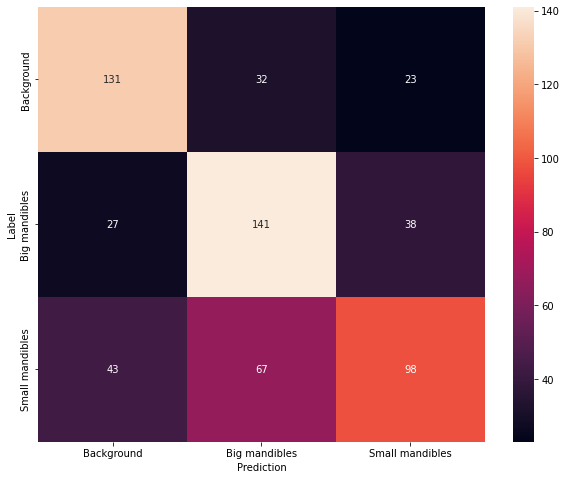

In [54]:
plot_confusion_matrix(classes, y_test, prediction)

# SEFR

In [70]:
sefr = SEFRMultiClass()
sefr.fit(X_train, y_train)

prediction = sefr.predict(X_test)
print(classification_report(np.asarray(y_test), prediction))

              precision    recall  f1-score   support

           0       0.35      0.30      0.32       186
           1       0.35      0.57      0.43       206
           2       0.39      0.21      0.27       208

    accuracy                           0.36       600
   macro avg       0.36      0.36      0.34       600
weighted avg       0.37      0.36      0.34       600



# RVM: Relevance Vector Machine

In [18]:
rvc = EMRVC(gamma='auto')
rvc.fit(X_train[0:1500], y_train[0:1500])
prediction = rvc.predict(X_test)
print(classification_report(np.asarray(y_test), prediction))

              precision    recall  f1-score   support

           0       0.57      0.82      0.67       186
           1       0.64      0.55      0.60       206
           2       0.61      0.45      0.52       208

    accuracy                           0.60       600
   macro avg       0.61      0.61      0.60       600
weighted avg       0.61      0.60      0.59       600



In [ ]:
from micromlgen.rvm import port_rvm

# NOT WORKING
c_code = port_rvm(rvc)
print(c_code)